In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy import math
import time

In [8]:
N = 100 # number of particles
steps = 1000  # number of simulation steps
xwidth = 10  # width of 10 particles in the x-direction
ywidth = N//xwidth  # width in the y-direction
a_av = 1  # average particle radius

k = 1  # repulsion coefficient
chi = 1  # rescaled translational viscosity
tau = 1  # characteristic time scale of repulsion
zeta = tau*k
dt = 0.1  # Monte Carlo simulation time step

labda_s = 0.04  # dimensionless parameter describing the strength of the self-propulsion
labda_a = 0.1  # alignment parameter
labda_n = 0.03  # noise parameter
labda_Fin = 0.3  # boundary force parameter
labda_Tin = 3  # boundary torque parameter

F_self = labda_s*k*a_av  # self-propulsion force
F_in = labda_Fin*k*a_av  # inward boundary force
T_in = labda_Tin*k*chi*zeta  # inward boundary torque
T_noise = np.sqrt(labda_n*2*k*chi**2/(zeta*dt))  # torque resulting from the noise
T_align = labda_a*k*chi/zeta  # torque which aligns the particles

xs = np.linspace(0, 2*(xwidth-1), xwidth)  # different initial x-positions
xpos = np.zeros((steps,N))  # array to hold all x-positions
ys = np.linspace(0, 2*(ywidth-1), ywidth)  # different initial y-positions
ypos = np.zeros((steps,N))  # array to hold all y-positions
a = np.zeros(N)  # array to hold all radii
psi = np.zeros((steps,N))  # array to hold all directions
xi = np.zeros(N)  # array to hold all 'noise orientations'
v = np.zeros(N)
F_angle = np.zeros(N)
omega = np.zeros(N)


In [9]:
# place the particles in a rectangular lattice and assign each particle a radius and initial direction

def initialise():
    global xwidth, xpos, xs, ypos, ywidth, ys, a, a_av, psi, N
    
    for i in range(0, xwidth):
        xpos[0][i::xwidth] = xs[i]

    for i in range(0, ywidth):
        ypos[0][(xwidth*i):(i+1)*xwidth] = ys[i]

    for i in range(0,N):  
        xpos[0,i] += np.random.uniform(-0.1, 0.1)  # giving the particles a small deviation from their original position
        ypos[0,i] += np.random.uniform(-0.1, 0.1)
        a[i] = np.random.normal(a_av, a_av/10) 
        psi[0,i] = np.pi/2 + np.random.uniform(-np.pi/2, np.pi/2)  # initially oriented along the y-axis (long edge for N > 100)


In [10]:
def perform_simulation_step():
    global boundary, theta_out, mismatch, N, xi, xdif_nb, ydif_nb, xpos_nb, ypos_nb, dist_nb, radius, orientation, angles, overlap
    global xdif, xpos, ydif, ypos, dist, a_av, psi, a, delta_psi, angle, d, repulsion_angles, F_rep_x, F_rep_y, sort_angles, x_av
    global y_av, diag, theta_in, delta_theta, F_bou, F_in, F_self, F_x, F_y, F, alpha, v, zeta, F_angle, T_n, T_noise, T_a, T_align
    global T_bou, T_in, T, omega, chi, step

    boundary = []
    theta_out = []
    mismatch = []

    for i in range(0,N):
        xi[i] = np.random.uniform(-1,1)
    
        xdif_nb = []
        ydif_nb = []
        xpos_nb = []
        ypos_nb = []
        dist_nb = []
        radius = []
        orientation = []
        angles = []
        overlap = []
        repulsion_angles = []

        # check if the particles are neighbours

        for j in range(0,N):  
            if i == j:
                continue
            xdif = xpos[step,i] - xpos[step,j]
            ydif = ypos[step,i] - ypos[step,j]
            dist = np.sqrt(xdif**2 + ydif**2)
            if dist < 2.7*a_av:
                xdif_nb = np.append(xdif_nb, xdif)
                ydif_nb = np.append(ydif_nb, ydif)
                xpos_nb = np.append(xpos_nb, xpos[step,j])
                ypos_nb = np.append(ypos_nb, ypos[step,j])
                dist_nb = np.append(dist_nb, dist)
                radius = np.append(radius, a[j])
                orientation = np.append(orientation, psi[step,j])

        # if the particle has no neighbours
                
        if len(xdif_nb) == 0:
            F = F_self 
            alpha = a[i]/a_av  # normalized radius
            v[i] = F/(alpha * zeta)
            F_angle[i] = psi[step,i]

            T_n = T_noise * xi[i]
            T = T_n
            omega[i] = T/(alpha**2 * chi)
            
        # if the particle has at least one neighbour
        
        else:
        
            # calculate the mismatch between neighbours for each particle

            delta_psi = 0
            for k in range(0, len(xdif_nb)):
                delta_psi += (orientation[k] - psi[step,i])

            mismatch = np.append(mismatch, delta_psi)

            # calculate the angle between neighbours in a clockwise direction

            for k in range(0, len(xdif_nb)):
                if ydif_nb[k] < 0:
                    angle = math.acos(xdif_nb[k]/dist_nb[k])
                if ydif_nb[k] > 0:
                    angle = np.pi + math.acos(-xdif_nb[k]/dist_nb[k])

                angles = np.append(angles, angle)
                repulsion_angles = np.append(repulsion_angles, np.mod((angle+np.pi), 2*np.pi))

            # calculate the overlap between neighbours for each particle

            for k in range(0, len(xdif_nb)):
                if (dist_nb[k] + a[i]) < radius[k]:
                    d = np.pi * a[i]**2
                elif (dist_nb[k] + radius[k]) < a[i]:
                    d = np.pi * radius[k]**2
                elif (a[i] + radius[k]) > dist_nb[k]:
                    d = (a[i]**2 * math.acos((dist_nb[k]**2 + a[i]**2 - radius[k]**2) / (2*dist_nb[k]*a[i]))
                         + radius[k]**2 * math.acos((dist_nb[k]**2 - a[i]**2 + radius[k]**2) / (2*dist_nb[k]*radius[k]))
                         - 0.5*np.sqrt((-dist_nb[k] + a[i] + radius[k])*(dist_nb[k] + a[i] - radius[k])
                         *(dist_nb[k] - a[i] + radius[k])*(dist_nb[k] + a[i] + radius[k])))
                else:
                    d = 0

                overlap = np.append(overlap, d)

            # calculate the repulsion forces in the x and y direction

            F_rep_x = 0
            F_rep_y = 0
            for k in range(0, len(overlap)):
                F_rep_x += (overlap[k] * (-math.cos(repulsion_angles[k])))
                F_rep_y += (overlap[k] * math.sin(repulsion_angles[k]))

            # check wether or not one of the angles is larger than pi.
            # if so, the particle is at the boundary

            sort_angles = np.sort(angles)  # sort the angles in order from smallest to largest

            if (2*np.pi - (sort_angles[len(sort_angles)-1] - sort_angles[0])) > np.pi:
                boundary = np.append(boundary,i)
                x_av = (xpos_nb[np.where(sort_angles[len(sort_angles)-1])] + xpos_nb[np.where(sort_angles[0])]) / 2
                y_av = (ypos_nb[np.where(sort_angles[len(sort_angles)-1])] + ypos_nb[np.where(sort_angles[0])]) / 2
                diag = np.sqrt((xpos[step,i] - x_av)**2 + (ypos[step,i] - y_av)**2)
                if (ypos[step,i] - y_av) > 0:
                    theta_in = math.acos((xpos[step,i] - x_av)/diag)
                if (ypos[step,i] - y_av) < 0:
                    theta_in = math.acos(-(xpos[step,i] - x_av)/diag)
                delta_theta = abs(theta_in - psi[step,i])
                F_bou = (np.pi - (sort_angles[len(sort_angles)-1] - sort_angles[0])) * F_in
                theta_out = np.append(theta_out, (2*np.pi - (sort_angles[len(sort_angles)-1] - sort_angles[0])))
            else:
                for k in range(0, (len(sort_angles)-1)):
                    if (sort_angles[(k+1)] - sort_angles[k]) > np.pi:
                        boundary = np.append(boundary,i)
                        x_av = (xpos_nb[np.where(sort_angles[(k+1)])] + xpos_nb[np.where(sort_angles[k])]) / 2
                        y_av = (ypos_nb[np.where(sort_angles[(k+1)])] + ypos_nb[np.where(sort_angles[k])]) / 2
                        diag = np.sqrt((xpos[step,i] - x_av)**2 + (ypos[step,i] - y_av)**2)
                        if (ypos[step,i] - y_av) > 0:
                            theta_in = math.acos((xpos[step,i] - x_av)/diag)
                        if (ypos[step,i] - y_av) < 0:
                            theta_in = math.acos(-(xpos[step,i] - x_av)/diag)
                        delta_theta = abs(theta_in - psi[step,i])
                        F_bou = (sort_angles[(k+1)] - sort_angles[k] - np.pi) * F_in
                        theta_out = np.append(theta_out, (sort_angles[(k+1)] - sort_angles[k]))
                        break
                    else:  # not on the boundary
                        F_bou = 0 
                        delta_theta = 0  # set to zero so that there is no boundary torque

            # calculate the net force on the particle and the angle

            F_x = (F_self + F_bou) * (-math.cos(psi[step,i])) + F_rep_x
            F_y = (F_self + F_bou) * math.sin(psi[step,i]) + F_rep_y
            F = np.sqrt(F_x**2 + F_y**2)

            alpha = a[i]/a_av  # normalized radius
            v[i] = F/(alpha * zeta)

            if F_y > 0:
                F_angle[i] = math.acos(F_x/F)
            if F_y < 0:
                F_angle[i] = math.acos(-F_x/F)

            #print("Force on particle " + str(i) + " is " + str(F))
            #print("Force on particle " + str(i) + " is working on an angle " + str(F_angle[i]))

            # calculate the torque on the particle

            T_n = T_noise * xi[i]
            T_a = T_align * delta_psi
            T_bou = T_in * delta_theta
            T = T_n + T_a + T_bou

            omega[i] = T/(alpha**2 * chi)

            #print("Torque on particle " + str(i) + " is " + str(T))

        #print("The particles at the boundary have number " + str(boundary))
        #print(v)
        #print(omega)
        #print(psi)
        #print(psi + omega*dt)
        #print(np.mod((psi + omega*dt), 2*np.pi))



In [11]:
def calculate_new_position():
    global xpos, ypos, v, dt, F_angle, step, N
    
    for i in range(0,N):
        xpos[step,i] = xpos[(step-1),i] + v[i]*dt*(-math.cos(F_angle[i]))
        ypos[step,i] = ypos[(step-1),i] + v[i]*dt*math.sin(F_angle[i])
    
def calculate_new_orientation():
    global psi, omega, dt, step
    
    psi[step] = np.mod((psi[step-1] + omega*dt), 2*np.pi)

0
100
200
300
400
500
600
700
800
900
44.60325982088682


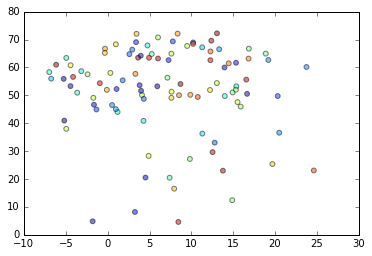

In [12]:
initialise()

step=0

start = time.clock()
while (step < steps):
    
    if (step%100 == 0):
        print(step)
    
    perform_simulation_step()
    
    step += 1
    
    if step < steps:
        calculate_new_position()
        calculate_new_orientation()      
    
print(time.clock() - start)    
    
area = np.pi*a[0]**2
colors = np.random.rand(N)

plt.scatter(xpos[step-1], ypos[step-1], s=10*area, c=colors, alpha=0.5)
plt.show()